# SEGMENTATION MODEL

### Prepare Library, Parameters, and Dependencies

In [59]:
%pip install -q git+https://github.com/tensorflow/examples.git --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import os
from tqdm import tqdm

%matplotlib inline

In [2]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  0


In [4]:
SEG_DATASET = "dataset/iris_needle_seg_dataset"
BATCH_SIZE_SEG = 8
VAL_RATIO_SEG = 0.2

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load Dataset

In [5]:
# USE THIS IF YOU USE LOCAL MACHINE

#Load OG Image Path
image_path = []
for root, dirs, files in os.walk(SEG_DATASET + "/train_original/"):
    for file in files:
        if file.endswith(".jpg"):
             image_path.append(os.path.join(root, file))
print(len(image_path))
print(image_path[1])

#Load Mask Image Path
mask_path = []
for root, dirs, files in os.walk(SEG_DATASET + "/train_mask/"):
    for file in files:
        if file.endswith(".jpg"):
             mask_path.append(os.path.join(root, file))
print(len(mask_path))
print(mask_path[1])

926
dataset/iris_needle_seg_dataset/train_original/SID0003_jpg.rf.0adbf1ee82977a127a39c223569e0251.jpg
926
dataset/iris_needle_seg_dataset/train_mask/SID0003_jpg.rf.0adbf1ee82977a127a39c223569e0251.jpg


In [6]:
#USE THIS IF YOU USE GOOGLE COLAB

# #Load OG Image and Mask Image Path
# image_path = []
# mask_path = []
# for root, dirs, files in os.walk('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/iris_needle_seg_dataset/train_original/'):
#     for file in files:
#         path_og = os.path.join(root,file)
#         path_mask = os.path.join('/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/iris_needle_seg_dataset/train_mask/',file)
#         image_path.append(path_og)
#         mask_path.append(path_mask)
# 
# print(len(image_path))
# print(image_path[1])
# 
# print(len(mask_path))
# print(mask_path[1])

### Decode Dataset Into Array

In [7]:
# USE THIS IF YOU USE LOCAL MACHINE

images = []
for path in tqdm(image_path):
    img = tf.io.read_file(path)
    img_array = tf.image.decode_png(img, channels=3, dtype=tf.uint8)
    images.append(img_array)

masks = []
for path in tqdm(mask_path):
    mask = tf.io.read_file(path)
    mask_array = tf.image.decode_png(mask, channels=1, dtype=tf.uint8)
    masks.append(mask_array)

100%|██████████| 926/926 [00:01<00:00, 484.50it/s]


In [8]:
#USE THIS IF YOU USE GOOGLE COLAB

# masks = []
# for path in tqdm(mask_path):
#     mask = tf.io.read_file(path)
#     mask_array = tf.image.decode_jpeg(mask, channels=1)
#     masks.append(mask_array)
# 
# images = []
# for path in tqdm(image_path):
#     img = tf.io.read_file(path)
#     img_array = tf.image.decode_jpeg(img, channels=3)
#     images.append(img_array)

### Visualize Dataset

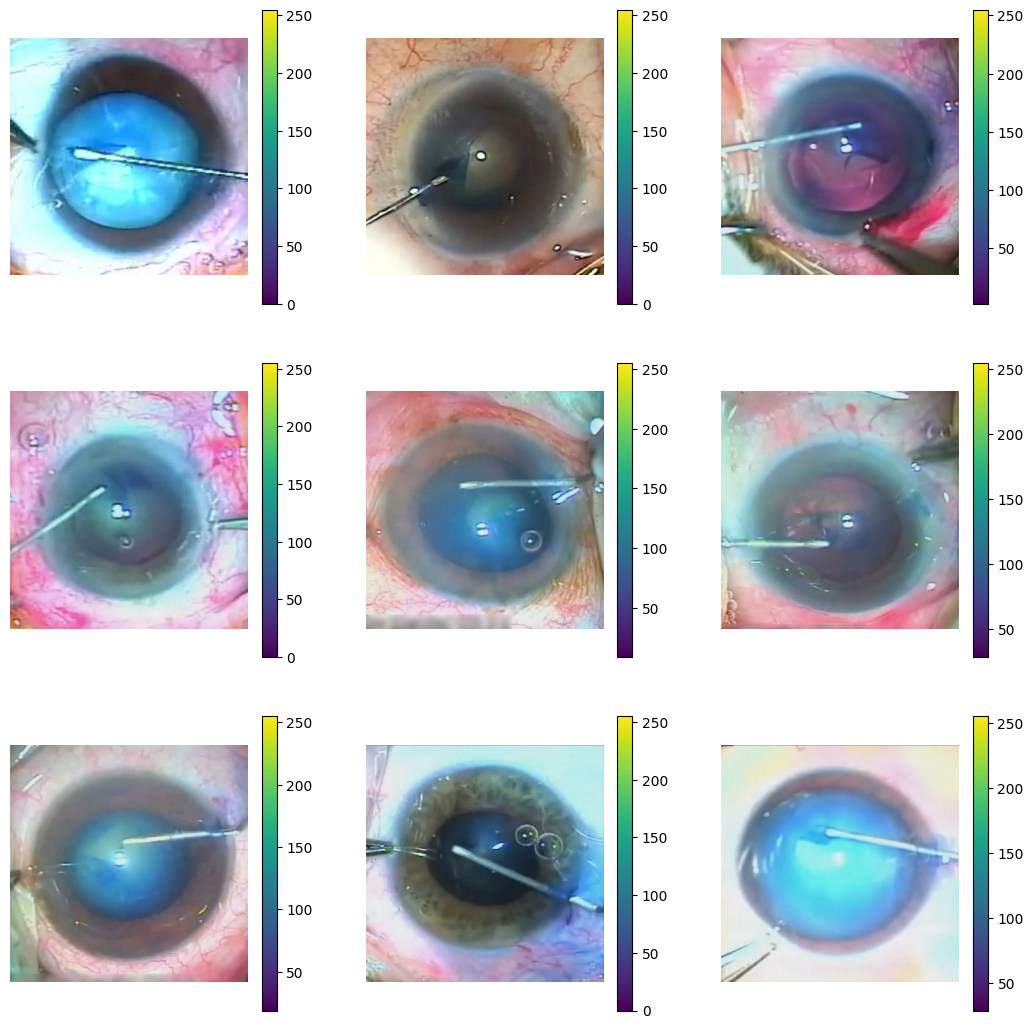

In [9]:
#Visualize Dataset OG Image
plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.colorbar()
    plt.axis("off")

plt.show()

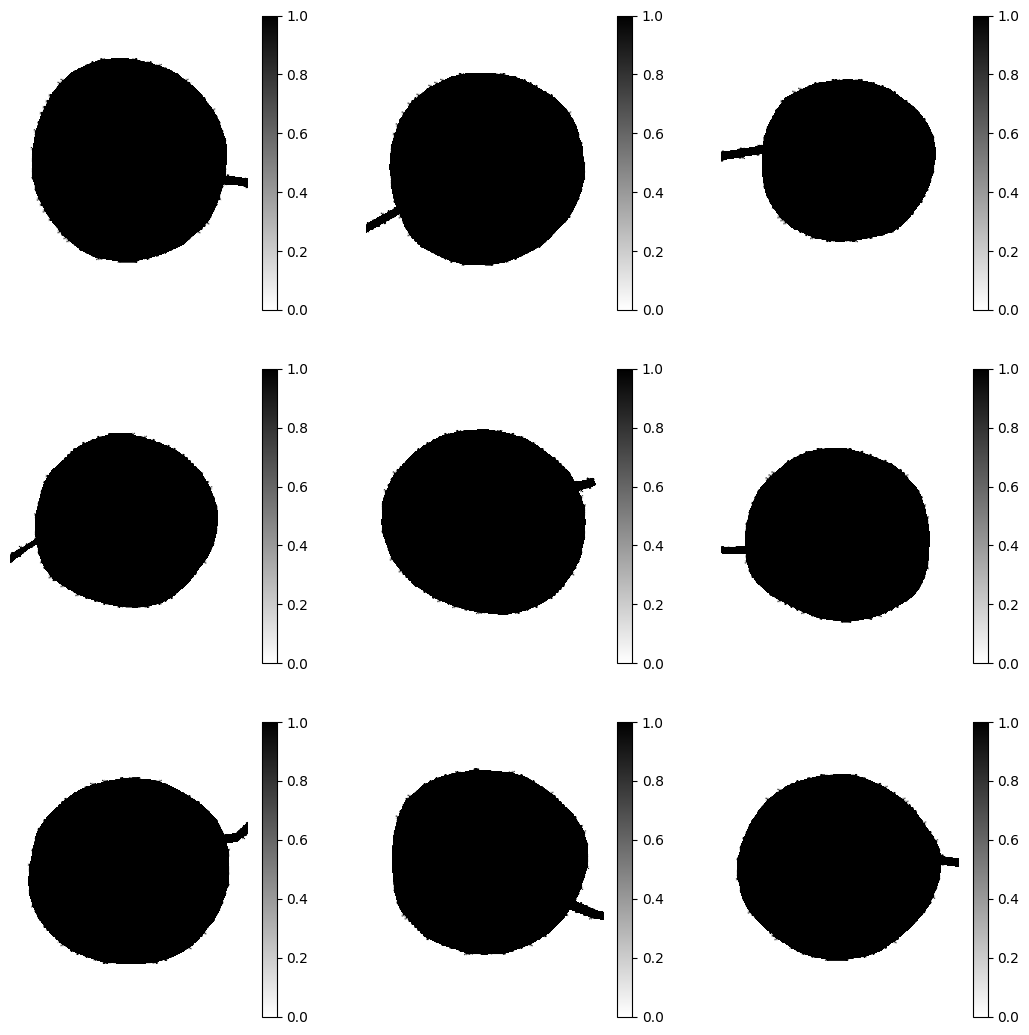

In [10]:
#Visualize Dataset Mask Image
NORM = mpl.colors.Normalize(vmin=0, vmax=1)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(masks[i], cmap='binary', norm=NORM)
    plt.colorbar()
    plt.axis("off")

plt.show()

### Resize Dataset

In [11]:
#Resize Dataset OG Image
def resize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image

#Resize Dataset Mask Image
def resize_mask(mask):
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return mask

X = [resize_image(image) for image in images]
y = [resize_mask(mask) for mask in masks]

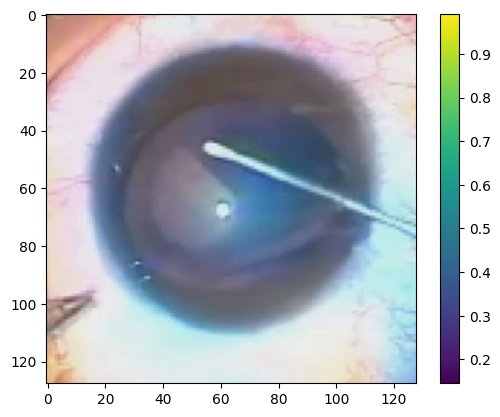

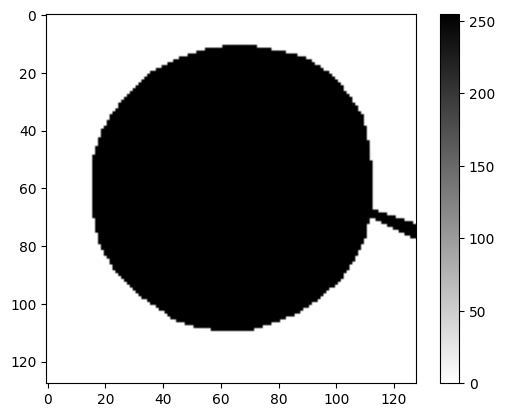

In [12]:
# Visualizing a Resized Image and Respective Mask

# Plot an OG Image
plt.imshow(X[36])
plt.colorbar()
plt.show()

# Plot a Mask
plt.imshow(y[36], cmap='binary')
plt.colorbar()
plt.show()

### Split Dataset & Chnage Dataset Into TensorFlow Dataset

In [13]:
# Split Dataset With 80/20 Ratio
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_RATIO_SEG, random_state=42)

# Change Dataset Into TensorFlow Dataset
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

### Dataset Augmentation

In [14]:
def brightness(image, mask):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, mask

def gamma(image, mask):
    image = tf.image.adjust_gamma(image, 0.1)
    return image, mask

def hue(image, mask):
    image = tf.image.adjust_hue(image, -0.1)
    return image, mask

def crop(image, mask):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.central_crop(mask, 0.7)
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.cast(mask, dtype=tf.uint8)
    return image, mask

def flip_hori(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def flip_vert(image, mask):
    image = tf.image.flip_up_down(image)
    mask = tf.image.flip_up_down(mask)
    return image, mask

def rotate(image, mask):
    image = tf.image.rot90(image)
    mask = tf.image.rot90(mask)
    return image, mask

In [15]:
# Zip Dataset
train = tf.data.Dataset.zip((X_train, y_train))
val = tf.data.Dataset.zip((X_val, y_val))

# Perform Data Augmentation
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(gamma))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(crop))
train = train.concatenate(train.map(flip_hori))
train = train.concatenate(train.map(flip_vert))
train = train.concatenate(train.map(rotate))

### Dataset Preparation

In [16]:
train = train.cache().shuffle(1000).batch(BATCH_SIZE_SEG).repeat()
train = train.prefetch(AUTOTUNE)
val = val.batch(BATCH_SIZE_SEG)

### Callback Function

In [17]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.9:
                print("\nReached 90% val_accuracy so cancelling training!")

                # Stop training once the above condition is met
                self.model.stop_training = True

stop_callback = myCallback()

### Build Model #1

In [18]:
base = tf.keras.applications.DenseNet121(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False, weights='imagenet')

In [19]:
skip_layer_names = [
    'conv1/relu', # size 64*64
    'pool2_relu',  # size 32*32
    'pool3_relu',  # size 16*16
    'pool4_relu',  # size 8*8
    'relu'        # size 4*4
]

In [20]:
skip_outputs = [base.get_layer(name).output for name in skip_layer_names]

downstack = tf.keras.Model(inputs=base.input, outputs=skip_outputs)

downstack.trainable = True

In [21]:
upstack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

down = downstack(inputs)
out = down[-1]

skips = reversed(down[:-1])

for up, skip in zip(upstack, skips):
    out = up(out)
    out = tf.keras.layers.Concatenate()([out,skip])

out = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same')(out)

unet = tf.keras.Model(inputs=inputs, outputs=out)

In [23]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 64),         7037504   ['input_2[0][0]']             
                              (None, 32, 32, 256),                                                
                              (None, 16, 16, 512),                                                
                              (None, 8, 8, 1024),                                                 
                              (None, 4, 4, 1024)]                                                 
                                                                                            

### Train Model #1

In [24]:
unet.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history = unet.fit(
    train,
    validation_data=val,
    steps_per_epoch=(len(X_train) // BATCH_SIZE_SEG),
    validation_steps=len(X_val) // BATCH_SIZE_SEG,
    epochs=50,
    callbacks=[stop_callback],
    verbose=2
)

### Evaluate Model

In [ ]:
# Select a Validation Data Batch
img, mask = next(iter(val))

# Make Prediction
pred = unet.predict(img)
plt.figure(figsize=(30,38))

k = 0
for i in pred:
    # Plot the Predicted Mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Prediction')

    # Plot the Groundtruth Mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(mask[k], cmap='jet', norm=NORM)
    plt.axis('off')
    plt.title('Ground Truth')

    # Plot the Actual Image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break

plt.suptitle('Prediction', color='red', size=20)
plt.show()